In [372]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

%matplotlib inline
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt

from pprint import pprint
import operator

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Data Exploration

Dataset is first loaded into dictionary and then explored. Key information about the data set is provided below.

In [373]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [374]:
# Structure of dataset
print "The general structure of the dataset is as follows:\n"
print (data_dict.items()[0])
print "\n"

### Key Information

# After some analysis and visualising data, an unnecessary data point, "TOTAL", was found to be present. As this
# is actually a sum of all other persons in dataset, its not useful here and is removed.
data_dict.pop('TOTAL', None)

# No. of persons in dataest
print "Total number of persons in dataset:", len(data_dict), "\n"

The general structure of the dataset is as follows:

('METTS MARK', {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38})


Total number of persons in dataset: 145 



In [375]:
# This is to see see how many data pts are available for each feature. Since there are 145 persons in total, the
# max number of data pts possible for a feature is 145. If number is too low, the feature is mostly NaN, and we 
# know it wouldn't be ideal to use that feature.
available_features_list = (data_dict.items()[0][1]).keys()
feature_count = {}
for feature in available_features_list:
    count = 0
    for values in data_dict.values():
        if values[feature] != "NaN":
            count += 1
    feature_count[feature] = count

sorted_feature_count = sorted(feature_count.items(), key=operator.itemgetter(1), reverse=True)
print "No. of data pts available for each features (descending order):\n"
print (sorted_feature_count)

No. of data pts available for each features (descending order):

[('poi', 145), ('total_stock_value', 125), ('total_payments', 124), ('email_address', 111), ('restricted_stock', 109), ('exercised_stock_options', 101), ('salary', 94), ('expenses', 94), ('other', 92), ('to_messages', 86), ('shared_receipt_with_poi', 86), ('from_messages', 86), ('from_poi_to_this_person', 86), ('from_this_person_to_poi', 86), ('bonus', 81), ('long_term_incentive', 65), ('deferred_income', 48), ('deferral_payments', 38), ('restricted_stock_deferred', 17), ('director_fees', 16), ('loan_advances', 3)]


In [376]:
cleaned_feature_list = []
for element in sorted_feature_count:
    if element[1]>=(145/2) and element[0]!="poi" and element[0]!="email_address" and element[0]!="other":
        cleaned_feature_list.append(element[0])

print cleaned_feature_list

['total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus']


# Feature Processing

In [377]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'bonus', 'total_stock_value', 'total_payments', 'restricted_stock', \
                 'exercised_stock_options', 'salary', 'expenses'] 

In [378]:
### Task 2: Remove outliers

In [379]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

In [380]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [381]:
### Split data into training data and test data
from sklearn.model_selection import train_test_split

# random_state = 42 is the seed for randomizing the split.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    

# Algorithms

<h3>PCA + Algos</h3>
<br>
Attempted deploying PCA to transform finance related features. Subsequently ran SVM, Decision Tree and K Nearest Neighbours algorithms on the transformed data.

In [382]:
### trying PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features_train)

#print pca.explained_variance_ratio_

#print "first pc", pca.components_[0]
#print "second pc", pca.components_[1]
#print "third pc", pca.components_[2]

trans_features_train = pca.transform(features_train)

# i=0
# for point in transformed_features:
#     x = point[0]
#     y = point[1]
#     plt.scatter( x, y )
#     if labels[i] == 1:
#         plt.scatter(x, y, color="r")
#     else:
#         plt.scatter(x, y, color="b")
#     i+=1

# plt.xlabel("x")
# plt.ylabel("y")
# plt.show()

In [383]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#params = {'C':[1,10,100,1000,10000], 'gamma':[1,10,100,1000,10000]}
svc = SVC(kernel='rbf')
svc.fit(trans_features_train, labels_train)

trans_features_test = pca.transform(features_test)
svc_pred = svc.predict(trans_features_test)

In [384]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(min_samples_split=10)
clf.fit(trans_features_train, labels_train)
tree_pred = clf.predict(trans_features_test)


In [385]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(trans_features_train, labels_train)
knn_pred = clf.predict(trans_features_test)

In [388]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(labels_test, svc_pred)
ps = precision_score(labels_test, svc_pred)
rs = recall_score(labels_test, svc_pred)

print "svc_acc:", acc
print "svc_precision_score:", ps
print "svc_recall_score:", rs

print "\n"

acc1 = accuracy_score(labels_test, tree_pred)
ps1 = precision_score(labels_test, tree_pred)
rs1 = recall_score(labels_test, tree_pred)

print "tree_acc:", acc1
print "tree_precision_score:", ps1
print "tree_recall_score:", rs1

print "\n"

acc2 = accuracy_score(labels_test, knn_pred)
ps2 = precision_score(labels_test, knn_pred)
rs2 = recall_score(labels_test, knn_pred)

print "knn_acc:", acc2
print "knn_precision_score:", ps2
print "knn_recall_score:", rs2

svc_acc: 0.860465116279
svc_precision_score: 0.0
svc_recall_score: 0.0


tree_acc: 0.837209302326
tree_precision_score: 0.0
tree_recall_score: 0.0


knn_acc: 0.837209302326
knn_precision_score: 0.0
knn_recall_score: 0.0


# Other Algos (in progress)

In [93]:
### Feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rescaled_features = scaler.fit_transform(features)
print rescaled_features[0:3]

[[  1.81735475e-01   5.21875000e-01   5.03529074e-02   4.33029255e-02]
 [  0.00000000e+00   0.00000000e+00   7.50594264e-03   1.76193863e-03]
 [  4.29243254e-04   0.00000000e+00   1.17797594e-01   8.84703391e-03]]


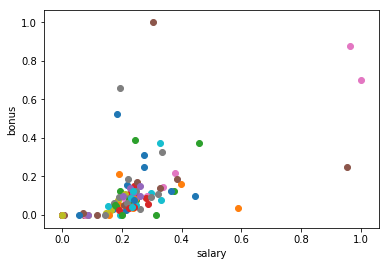

In [94]:
### Visualizing data
for point in rescaled_features:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [109]:
### Split data into training data and test data
from sklearn.model_selection import train_test_split

# random_state = 42 is the seed for randomizing the split.
features_train, features_test, labels_train, labels_test = \
    train_test_split(rescaled_features, labels, test_size=0.3, random_state=4)
    
print labels_test
print labels

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [110]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# pca.fit(features)

# pipe = make_pipeline(PCA())
# #pipe.set_params(pca__n_components=5)
# pipe

In [111]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html



# Create a dictionary to store pred value of various classifiers
pred_dict = {}

# Provided to give you a starting point. Try a variety of classifiers.
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

In [112]:
# Classifier 1: Decision Tree
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

pred_dict['decision_tree'] = pred

In [113]:
# Classifier 2: SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {'C':[1,10,100,1000,10000], 'gamma':[1,10,100,1000,10000]}
svc = SVC(kernel='rbf')
clf = GridSearchCV(svc, params)
clf.fit(features_train, labels_train)
print clf.best_params_

pred = clf.predict(features_test)


pred_dict['SVM'] = pred

{'C': 1, 'gamma': 1}


In [115]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# # Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)
    

#evaluation    
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from pprint import pprint
print labels_test
pprint(pred_dict)

for key, value in pred_dict.items():
    print key.upper()
    acc = accuracy_score(labels_test, value)
    ps = precision_score(labels_test, value)
    rs = recall_score(labels_test, value)

    print "acc:", acc
    print "precision_score:", ps
    print "recall_score:", rs
    print "\n"

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
{'PCA_SVM': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.]),
 'SVM': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.]),
 'decision_tree': array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.])}
DECISION_TREE
acc: 0.8333333333

In [64]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)